In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy


Loading BokehJS ...

# GAS Model

In [2]:
dat0 = pd.read_csv('ch4k_df_eu.csv', low_memory = False, index_col = 0)

In [363]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
#     if  (alpha > 0) and (sigma > 0) and (beta > alpha) : # *these are problematic maybe...???

    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

### Estimate a GAS model

In [10]:
dat = dat0.copy()
dat = dat[(dat.season == 'SS19') & (dat.country == 'EU') & (dat.season_net_qty > 1000)]
dat.reset_index(inplace = True)
dat.sort_values(['article_number', 'year', 'week'], inplace = True)
dat.set_index('article_number', inplace = True)

In [ ]:
# dat.reset_index(inplace=True)

# a = pd.DataFrame(dat.groupby('article_number')['net_qty'].sum())
# b = dat[['article_number', 'season_net_qty']].drop_duplicates()
# c = pd.merge(a, b, left_index=True, right_on='article_number')
# c[np.abs(c.net_qty - c.season_net_qty) > 100]

In [489]:
%%time

a = np.random.choice(dat.index.unique(), size = 1, replace = False)
print('Article:', a[0])

dat_a = dat[(dat.index == a[0])].copy()

# dat.reset_index(inplace = True)
# dat.sort_values(by = ['article_number', 'year', 'week'], inplace = True)

dat_a.sort_values(by = ['year', 'week'], inplace = True)

# dat.set_index(['article_number'], inplace = True)
print()
print('Number of weeks:', dat_a['year'].count())

y = dat_a.net_qty.values # observed demand -- basically the response variable
x = dat_a.buy_availability.values # basically the explanatory variable

y = y.reshape((len(y),1)) 
x = x.reshape((len(y),1))

print()

# from scipy import optimize # --------------
# par_ranges = (slice(0.01, 1.01, 0.1), 
#               slice(0.01, 1.01, 0.1), 
#               slice(0.01, np.mean(y)*1.5, 5), 
#               slice(0.01, 1.01, 0.1), 
#               slice(0.01, np.mean(y)*1.5, 5)
#              )
# x0_brute = scipy.optimize.brute(loglikest, par_ranges, args = (y, x), finish = None)
# print('x0_brute', x0_brute) # ----------------

x0 = np.array([0.5, 0.6, np.mean(y), 1, np.mean(y)]) # starting value for optimisation
            # alpha, beta, omega, sigma, f0
            # See initialize_parameters for ordering
        
# # function to minimize log likelihood of observed values given parameters
res = scipy.optimize.minimize(loglikest, 
                              x0,        # initial parameter values (starting)
                              args=(y, x), 
                                  # y1: obs demand
                                  # x: buy_availability
                              options ={'eps':1e-09, 'maxiter': 100, 'ftol': 1e-12},
                              method = 'L-BFGS-B', # 'TNC', , 'SLSQP'
                              bounds =((0,  None),            # alpha
                                      (-1, 1),                # beta
                                      (0.001, np.mean(y)*2),  # omega 
                                      (0.001, 1),             # sigma
                                      (0.001, np.mean(y)*2)   # f0
                                     ),
                              # constraints = ({'type': 'ineq', 'fun': lambda x: x[1] - x[0]}) # (beta > alpha)
                             )
# print(res)

x1 = res.x.round(1) # numpy.ndarray, (5,)

print('Message:', res.message)
print()
print('Iterations:', res.nit)
print()
print('Param est conv\'g:', res.success)
print()
print('alpha:', x1[0])
print('beta:', x1[1])
print('omega:', x1[2])
print('sigma:', x1[3])
print('f0:', x1[4])
print()


Article: AH2562

Number of weeks: 27

Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

Iterations: 97

Param est conv'g: True

alpha: 1.7
beta: -0.2
omega: 63.6
sigma: 1.0
f0: 5.8

CPU times: user 951 ms, sys: 58.4 ms, total: 1.01 s
Wall time: 960 ms


1059.0

837

Text(0.5, 1.0, 'Observed & Estimated Gross Demand Quantity')

Text(0.5, 1.0, 'Buy Availability')

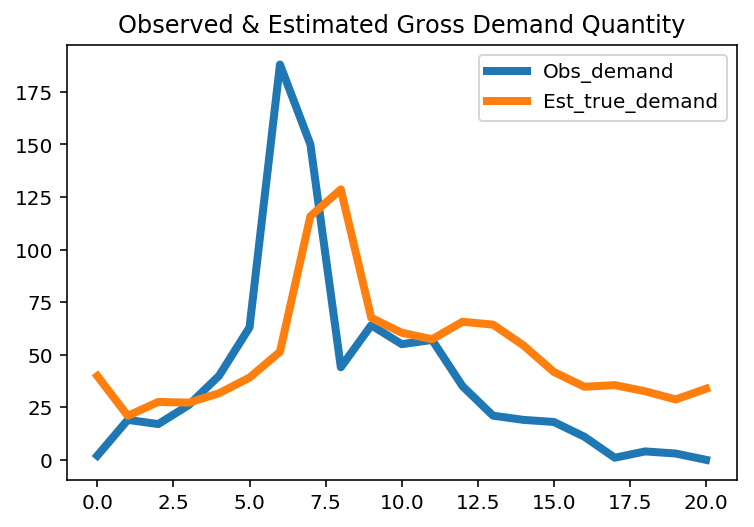

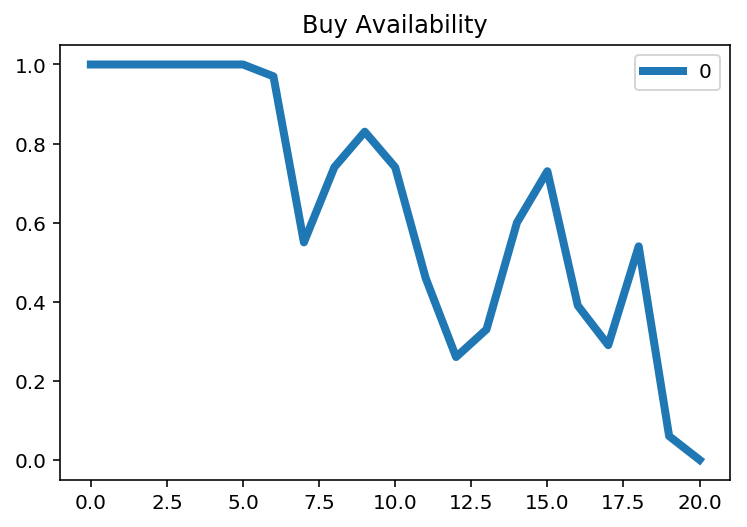

In [488]:
# Get estimated parameters and filter out the demand

# x1par = initialize_parameters(res.x)
x1par = initialize_parameters(x0)
f_est = filterGAS(y, x, x1par)

d = pd.DataFrame({'Obs_demand': y[:,0], 'Est_true_demand': f_est[:,0]})

# total real demand
round(np.sum(f_est))

# total observed demand
np.sum(y)

pd.DataFrame(data = d).plot(linewidth = 4)
# plt.ylim(0, 1200)
plt.title('Observed & Estimated Gross Demand Quantity')

pd.DataFrame(x).plot(linewidth = 4)
plt.title('Buy Availability')
#plt.ylabel('Real Data')

# Applied

In [ ]:
dat0 = pd.read_csv('ch4k_df_eu.csv', low_memory = False, index_col = 0)

In [ ]:
dat = dat0.copy()
dat.reset_index(inplace = True)
dat = dat[(dat.season == 'SS19') & (dat.country == 'EU') & (dat.season_net_qty > 1000)]

dat.sort_values(['article_number', 'year', 'week'], inplace = True)

dat.set_index(['article_number'], inplace = True)

In [ ]:
# len(dat.index.unique())
# dat.head()
# dat[(dat.index == '011040') &
#          (dat.week == 1)]

In [ ]:
a = np.random.choice(dat.index.unique(), size = 1, replace = False)
print(a)
g = dat.loc[a ,:].copy()
# dat_samp.reset_index(inplace = True)


# def GAS_est(g):
    # y: observed demand
    # x: buy_availability
    
g.sort_values(["year", "week"], inplace=True)

y = g['net_qty'].values
x = g['buy_availability'].values

y = y.reshape((len(y),1)) 
x = x.reshape((len(y),1))

x0 = np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]) # # initial parameter values (starting)

res = scipy.optimize.minimize(
    loglikest, # function to minimize (log likelihood y|x,theta)
    x0,        
    args=(y, x), 
    # y1: obs demand
    # x: buy_availability
    options ={'eps':1e-09, 'maxiter': 50},
    method='L-BFGS-B', 
    bounds=((0,  1),                # alpha
            (-0.99, 0.99),          # beta
            (0.001, np.mean(y)*2),  # omega 
            (0.001, 1),             # sigma
            (0.001, np.mean(y)*2)   # f
           )
)

print(res.success)

x1par = initialize_parameters(res.x) 
f_est = filterGAS(y, x, x1par)
    
    
out = pd.DataFrame()

out["year"] = g["year"].values
out["week"] = g["week"].values
out['Convergence'] = res.success
out['f_est'] = f_est[:,0]

out
    
#     return out

In [ ]:
a = np.random.choice(dat.index.unique(), size = 1, replace = False)
print(a)
dat_samp = dat.loc[a ,:]
dat_samp.reset_index(inplace = True)

# f_est1 = GAS_est(dat_samp.net_qty, dat_samp.buy_availability) # numpy.ndarray, (27, 1)

# tt = dat_samp.groupby(["article_number", "year", "week"]).agg({'cost':'count'})
# tt.loc[tt.cost > 1,:]

# 100 articles = 14 s
# 1000 articles = 2min 47s
# 5000 articles = 24 min

d = dat_samp.groupby(["article_number"]).apply(lambda g: GAS_est(g))
d.reset_index(inplace = True)

d = pd.merge(dat_samp, d, left_on=['article_number', 'year', 'week'], right_on=['article_number', 'year', 'week'])

In [ ]:
d

In [ ]:
pd.DataFrame(data = d_samp[['net_qty', 'f_est']])

In [ ]:
a = np.random.choice(d.article_number, size = 1)
a[0]

d_samp = d[d.article_number == a[0]]
d_samp.head()


print('Estimated actual:', round(np.sum(d_samp.f_est))) # estimated total actual demand
print('Observed:', np.sum(d_samp.net_qty)) # total observed demand

pd.DataFrame(data = d_samp[['net_qty', 'f_est']]).plot(linewidth = 4)
plt.title('Observed & Estimated Gross Demand Quantity')

pd.DataFrame(d_samp.buy_availability).plot(linewidth = 4)
plt.ylim(0, 1)

plt.title('Buy Availability')
plt.ylabel('Real Data')

In [ ]:
# ------------------------- Appendix --------------------------- 

In [ ]:
# def GAS_est(y, x):
#     # y: observed demand
#     # x: buy_availability
    
#     y = y.values
#     x = x.values
    
#     y = y.reshape((len(y),1)) 
#     x = x.reshape((len(y),1))
    
#     x0 = np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]) # # initial parameter values (starting)
    
#     res = scipy.optimize.minimize(
#         loglikest, # function to minimize (log likelihood y|x,theta)
#         x0,        
#         args=(y, x), 
#         # y1: obs demand
#         # x: buy_availability
#         options ={'eps':1e-09},
#         method='L-BFGS-B', 
#         bounds=((0,  1),                # alpha
#                 (-0.99, 0.99),          # beta
#                 (0.001, np.mean(y)*2),  # omega 
#                 (0.001, 1),             # sigma
#                 (0.001, np.mean(y)*2)   # f
#                )
#     )
    
#     x1par = initialize_parameters(res.x) 
#     f_est = filterGAS(y, x, x1par)
    
#     return f_est[:,0]
    

# d = dat_samp.groupby(dat_samp.index, as_index=False).apply(lambda df: GAS_est(df['net_qty'], df['buy_availability']))

# d = d.to_dict()

# wtf = pd.DataFrame()

# for k in d.keys():
#     df = pd.DataFrame(data = d[k], index = [k] * d[k].shape[0], columns = ['f_est'])
#     wtf = wtf.append(df)
#     # wtf = wtf.append(pd.DataFrame(data = d[k], index = [k] * d[k].shape[0], columns = ['f_est']))

# dat_samp2.sort_index(inplace = True)
# wtf.sort_index(inplace = True)
# fme = pd.concat([dat_samp2, wtf], axis = 1)

# plt = fme.loc[np.random.choice(fme.index, size = 1),:]
# plt1 = plt[['net_qty', 'f_est']]

# plt1.plot(linewidth = 4)

# pd.DataFrame(plt['buy_availability']).plot(linewidth = 4)

In [ ]:
# dictEst = {}
# dictEst[np.random.choice(dat.index, size = 1).item()] = f_est1.reshape(f_est1.shape[0],).tolist()

# dictEst
# pd.DataFrame(dictEst)